In [1]:
import json
import os
from typing import Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from collect import (
    GROUP_MAP,
    GROUP_MAP_CEQ,
    GROUP_MAP_CW,
    MAP_AUDIO_TASK,
    AUDIO_TASK_PERFORMANCE_METRIC,
    MAP_MODEL_NAME,
    MODEL_ORDER,
    GROUP_ORDER_CEQ,
    GROUP_ORDER_CW,
)

In [3]:
df_audio_task_ceq = {}
for audio_task in MAP_AUDIO_TASK.keys():
    df_audio_task_ceq[audio_task] = pd.read_excel(f"summary_ceq.xlsx", sheet_name=f"{audio_task}_grouped")

df_audio_task_cot = {}
for audio_task in MAP_AUDIO_TASK.keys():
    df_audio_task_cot[audio_task] = pd.read_excel(f"summary_CoT.xlsx", sheet_name=audio_task)

df_audio_task_cw = {}
for audio_task in MAP_AUDIO_TASK.keys():
    if audio_task == "MMAU":
        continue
    df_audio_task_cw[audio_task] = pd.read_excel(f"summary_cw.xlsx", sheet_name=f"{audio_task}_grouped")

In [4]:
df_audio_task_cw.keys()

dict_keys(['ASR', 'SER', 'GR'])

In [5]:
outs = {}
for k, v in df_audio_task_ceq.items():
    outs[k] = []
    for shot_level in v["shot_level"].unique():
        tmp = v.loc[v["shot_level"].eq(shot_level)].copy()
        tmp["model"] = pd.Categorical(tmp["model"], categories=MODEL_ORDER, ordered=True)
        tmp["IF_task_group"] = pd.Categorical(tmp["IF_task_group"], categories=GROUP_ORDER_CEQ, ordered=True)

        out = tmp.pivot_table(
            index="model",
            columns="IF_task_group",
            values="if_rate_strict",
            aggfunc="mean",
            observed=False,
            sort=False,
        )
        outs[k].append(out)

# CEQ

In [6]:
DF_audio_task_ceq = pd.concat(
    list(df_audio_task_ceq.values()),
    keys=list(df_audio_task_ceq.keys()),
    names=["audio_task"]
).reset_index()

In [7]:
DF_ceq = DF_audio_task_ceq.groupby(["IF_task_group", "model", "shot_level"]).mean(numeric_only=True).reset_index()
DF_ceq["model"] = pd.Categorical(DF_ceq["model"], categories=MODEL_ORDER, ordered=True)
DF_ceq["IF_task_group"] = pd.Categorical(DF_ceq["IF_task_group"], categories=GROUP_ORDER_CEQ, ordered=True)

In [8]:
pt_ceq = DF_ceq.pivot_table(
    index=["model", "shot_level"],
    columns="IF_task_group",
    values="if_rate_strict",
    aggfunc="mean",
    observed=False,
    sort=False,
)
pt_ceq["Avg."] = pt_ceq.mean(axis=1)

In [9]:
pt_0 = pt_ceq.loc[:, 0, :]
pt_k = pt_ceq[pt_ceq.index.get_level_values("shot_level") > 0].groupby("model", observed=False).mean()
tb_ceq = pd.concat([pt_0, pt_k], keys=["Zero-shot", "ICL"], names=["Setting"])
tb_ceq = tb_ceq.swaplevel("Setting", "model").reset_index().sort_values("model").set_index(["model", "Setting"])
round(tb_ceq * 100, 2)

IF_task_group                            change_case  startend  wrapping  \
model                         Setting                                      
qwen2                         Zero-shot        77.61     65.92     20.32   
                              ICL              55.31     68.67     20.33   
desta2_5                      Zero-shot        99.40     94.38     93.50   
                              ICL              94.25     63.08     81.34   
blsp-emo                      Zero-shot        66.67     61.92     38.11   
                              ICL              50.07     45.66     51.82   
qwen25_omni                   Zero-shot        96.31     90.38     91.34   
                              ICL              51.62     58.54     51.94   
gemini-2.5-flash              Zero-shot        98.20    100.00    100.00   
                              ICL              58.85     88.84     61.38   
gemini-3-flash-preview        Zero-shot        99.45    100.00     99.50   
                              ICL              64.31     94.94     70.69   
cascade_qwen25-7b-instruct    Zero-shot        98.45    100.00     99.50   
                              ICL              79.03     91.74     76.25   
cascade_llama-3_1-8b-instruct Zero-shot        99.00     88.17     90.92   
                              ICL              95.22     74.01     92.50   

IF_task_group                            json_format   Avg.  
model                         Setting                        
qwen2                         Zero-shot         0.00  40.96  
                              ICL               0.25  36.14  
desta2_5                      Zero-shot        98.54  96.45  
                              ICL              37.64  69.08  
blsp-emo                      Zero-shot        95.83  65.63  
                              ICL               1.88  37.36  
qwen25_omni                   Zero-shot        73.36  87.85  
                              ICL               8.34  42.61  
gemini-2.5-flash              Zero-shot       100.00  99.55  
                              ICL              50.90  64.99  
gemini-3-flash-preview        Zero-shot       100.00  99.74  
                              ICL              50.74  70.17  
cascade_qwen25-7b-instruct    Zero-shot        96.12  98.52  
                              ICL              49.37  74.10  
cascade_llama-3_1-8b-instruct Zero-shot        90.37  92.11  
                              ICL              59.13  80.21

In [10]:
tb_ceq.to_csv("tables_ceq.csv", index=True)

# CW

In [11]:
DF_audio_task_cw = pd.concat(
    list(df_audio_task_cw.values()),
    keys=list(df_audio_task_cw.keys()),
    names=["audio_task"]
).reset_index().drop(columns=["level_1"]).dropna()
DF_audio_task_cw["model"] = pd.Categorical(DF_audio_task_cw["model"], categories=MODEL_ORDER, ordered=True)
DF_audio_task_cw["IF_task_group"] = pd.Categorical(DF_audio_task_cw["IF_task_group"], categories=GROUP_ORDER_CW, ordered=True)

pt_cw = DF_audio_task_cw.groupby(["IF_task_group", "model", "shot_level"], observed=False).mean(numeric_only=True)
pt_cw = pt_cw.reset_index().pivot_table(
    index=["model", "shot_level"],
    columns="IF_task_group",
    values="if_rate",
    aggfunc="mean",
    observed=False,
    sort=False,
)
pt_cw["Avg."] = pt_cw.mean(axis=1)

In [12]:
pt_0_cw = pt_cw.loc[:, 0, :]
pt_k_cw = pt_cw[pt_cw.index.get_level_values("shot_level") > 0].groupby("model", observed=False).mean()
tb_cw = pd.concat([pt_0_cw, pt_k_cw], keys=["Zero-shot", "ICL"], names=["Setting"])
tb_cw = tb_cw.swaplevel("Setting", "model").reset_index().sort_values("model").set_index(["model", "Setting"])
tb_cw.to_csv("tables_cw.csv", index=True)
round(tb_cw * 100, 2)

IF_task_group                            bullet_lists  keywords  \
model                         Setting                             
qwen2                         Zero-shot         82.78     75.00   
                              ICL               78.10     81.75   
desta2_5                      Zero-shot         90.93     86.00   
                              ICL               96.69     88.12   
blsp-emo                      Zero-shot         76.85     53.00   
                              ICL               97.81     55.12   
qwen25_omni                   Zero-shot          0.93     83.00   
                              ICL               96.15     89.25   
gemini-2.5-flash              Zero-shot         96.48    100.00   
                              ICL               99.90     99.50   
gemini-3-flash-preview        Zero-shot         99.17    100.00   
                              ICL              100.00     99.88   
cascade_qwen25-7b-instruct    Zero-shot         88.52     92.00   
                              ICL               96.27     96.75   
cascade_llama-3_1-8b-instruct Zero-shot         85.83     87.00   
                              ICL               84.90     94.00   

IF_task_group                            length_constraints   Avg.  
model                         Setting                               
qwen2                         Zero-shot               54.33  70.70  
                              ICL                     56.79  72.21  
desta2_5                      Zero-shot               80.65  85.86  
                              ICL                     90.71  91.84  
blsp-emo                      Zero-shot               59.37  63.07  
                              ICL                     70.51  74.48  
qwen25_omni                   Zero-shot               60.38  48.10  
                              ICL                     68.14  84.51  
gemini-2.5-flash              Zero-shot               93.01  96.50  
                              ICL                     93.42  97.61  
gemini-3-flash-preview        Zero-shot               97.63  98.93  
                              ICL                     97.33  99.07  
cascade_qwen25-7b-instruct    Zero-shot               55.60  78.71  
                              ICL                     64.07  85.70  
cascade_llama-3_1-8b-instruct Zero-shot               83.24  85.36  
                              ICL                     86.97  88.62

# CoT

In [13]:
DF_audio_task_cot = pd.concat(
    list(df_audio_task_cot.values()),
    keys=list(df_audio_task_cot.keys()),
).reset_index().rename(columns={"level_0": "audio_task"})
DF_audio_task_cot["model"] = pd.Categorical(DF_audio_task_cot["model"], categories=MODEL_ORDER, ordered=True)
pt_cot = DF_audio_task_cot.groupby(["model", "shot_level"], observed=False).mean(numeric_only=True)
pt_cot = pt_cot.reset_index().pivot_table(
    index=["model", "shot_level"],
    values="New CoT Acc",
    aggfunc="mean",
    observed=False,
    sort=False,
)

In [14]:
pt_0_cot = pt_cot.loc[:, 0, :]
pt_k_cot = pt_cot[pt_cot.index.get_level_values("shot_level") > 0].groupby("model", observed=False).mean()
tb_cot = pd.concat([pt_0_cot, pt_k_cot], keys=["Zero-shot", "ICL"], names=["Setting"])
tb_cot = tb_cot.swaplevel("Setting", "model").reset_index().sort_values("model").set_index(["model", "Setting"])
tb_cot.to_csv("tables_cot.csv", index=True)
round(tb_cot * 100  , 2)

New CoT Acc
model                         Setting               
qwen2                         Zero-shot        30.59
                              ICL              62.39
desta2_5                      Zero-shot        92.49
                              ICL              99.06
blsp-emo                      Zero-shot        57.85
                              ICL              94.62
qwen25_omni                   Zero-shot        58.91
                              ICL              81.33
gemini-2.5-flash              Zero-shot        97.37
                              ICL              99.92
gemini-3-flash-preview        ICL                NaN
cascade_qwen25-7b-instruct    ICL                NaN
cascade_llama-3_1-8b-instruct Zero-shot        91.31
                              ICL              93.09

In [15]:
tb_if = pd.concat([tb_ceq, tb_cw, tb_cot], axis=1, keys=["CEQ", "CW", "CoT"])
tb_if.to_csv("tables_if_rate.csv", index=True)
round(tb_if, 4) * 100

CEQ                    \
                                        change_case startend wrapping   
model                         Setting                                   
qwen2                         Zero-shot       77.61    65.92    20.32   
                              ICL             55.31    68.67    20.33   
desta2_5                      Zero-shot       99.40    94.38    93.50   
                              ICL             94.25    63.08    81.34   
blsp-emo                      Zero-shot       66.67    61.92    38.11   
                              ICL             50.07    45.66    51.82   
qwen25_omni                   Zero-shot       96.31    90.38    91.34   
                              ICL             51.62    58.54    51.94   
gemini-2.5-flash              Zero-shot       98.20   100.00   100.00   
                              ICL             58.85    88.84    61.38   
gemini-3-flash-preview        Zero-shot       99.45   100.00    99.50   
                              ICL             64.31    94.94    70.69   
cascade_qwen25-7b-instruct    Zero-shot       98.45   100.00    99.50   
                              ICL             79.03    91.74    76.25   
cascade_llama-3_1-8b-instruct Zero-shot       99.00    88.17    90.92   
                              ICL             95.22    74.01    92.50   

                                                                     CW  \
                                        json_format   Avg. bullet_lists   
model                         Setting                                     
qwen2                         Zero-shot        0.00  40.96        82.78   
                              ICL              0.25  36.14        78.10   
desta2_5                      Zero-shot       98.54  96.45        90.93   
                              ICL             37.64  69.08        96.69   
blsp-emo                      Zero-shot       95.83  65.63        76.85   
                              ICL              1.88  37.36        97.81   
qwen25_omni                   Zero-shot       73.36  87.85         0.93   
                              ICL              8.34  42.61        96.15   
gemini-2.5-flash              Zero-shot      100.00  99.55        96.48   
                              ICL             50.90  64.99        99.90   
gemini-3-flash-preview        Zero-shot      100.00  99.74        99.17   
                              ICL             50.74  70.17       100.00   
cascade_qwen25-7b-instruct    Zero-shot       96.12  98.52        88.52   
                              ICL             49.37  74.10        96.27   
cascade_llama-3_1-8b-instruct Zero-shot       90.37  92.11        85.83   
                              ICL             59.13  80.21        84.90   

                                                                            \
                                        keywords length_constraints   Avg.   
model                         Setting                                        
qwen2                         Zero-shot    75.00              54.33  70.70   
                              ICL          81.75              56.79  72.21   
desta2_5                      Zero-shot    86.00              80.65  85.86   
                              ICL          88.12              90.71  91.84   
blsp-emo                      Zero-shot    53.00              59.37  63.07   
                              ICL          55.12              70.51  74.48   
qwen25_omni                   Zero-shot    83.00              60.38  48.10   
                              ICL          89.25              68.14  84.51   
gemini-2.5-flash              Zero-shot   100.00              93.01  96.50   
                              ICL          99.50              93.42  97.61   
gemini-3-flash-preview        Zero-shot   100.00              97.63  98.93   
                              ICL          99.88              97.33  99.07   
cascade_qwen25-7b-instruct    Zero-shot    92.00              55

In [16]:
DF_audio_task_ceq["model"] = pd.Categorical(DF_audio_task_ceq["model"], categories=MODEL_ORDER, ordered=True)
DF_audio_task_ceq.groupby(["model", "audio_task", "shot_level"], observed=False).mean(numeric_only=True)

level_1      n  \
model                         audio_task shot_level                   
qwen2                         ASR        0              12.0  31.25   
                                         1              44.0  31.25   
                                         2              76.0  31.25   
                                         3             108.0  31.25   
                                         4             140.0  31.25   
...                                                      ...    ...   
cascade_llama-3_1-8b-instruct SER        4             147.0  31.25   
                                         5             179.0  31.25   
                                         6             211.0  31.25   
                                         7             243.0  31.25   
                                         8             275.0  31.25   

                                                     if_rate_strict  \
model                         audio_task shot_level                   
qwen2                         ASR        0                    0.450   
                                         1                    0.425   
                                         2                    0.325   
                                         3                    0.365   
                                         4                    0.340   
...                                                             ...   
cascade_llama-3_1-8b-instruct SER        4                    0.810   
                                         5                    0.795   
                                         6                    0.775   
                                         7                    0.730   
                                         8                    0.675   

                                                     if_rate_loose  \
model                         audio_task shot_level                  
qwen2                         ASR        0                   0.450   
                                         1                   0.425   
                                         2                   0.325   
                                         3                   0.365   
                                         4                   0.340   
...                                                            ...   
cascade_llama-3_1-8b-instruct SER        4                   0.810   
                                         5                   0.795   
                                         6                   0.775   
                                         7                   0.730   
                                         8                   0.675   

                                                     mean_performance  
model                         audio_task shot_level                    
qwen2                         ASR        0                   0.353023  
                                         1                   0.305942  
                                         2                   0.243228  
                                         3                   0.244475  
                                         4                   0.231513  
...                                                               ...  
cascade_llama-3_1-8b-instruct SER        4                   0.550000  
                                         5                   0.525000  
                                         6                   0.530000  
                                         7                   0.515000  
                                         8                   0.495000  

[288 rows x 5 columns]

In [17]:
DF_audio_task_ceq = DF_audio_task_ceq.rename(columns={"if_rate_strict": "IF Rate"})
DF_audio_task_cw = DF_audio_task_cw.rename(columns={"if_rate": "IF Rate"})
DF_audio_task_cot["mean_performance"] = DF_audio_task_cot["New Task Acc"].fillna(0) + DF_audio_task_cot["New task wer"].fillna(0)
DF_audio_task_cot = DF_audio_task_cot.rename(columns={"CoT Acc": "IF Rate"})

In [18]:
AUDIO_TASK_PERFORMANCE_METRIC

{'ASR': 'wer',
 'SER': 'answer_correct',
 'GR': 'answer_correct',
 'MMAU': 'answer_correct'}

In [19]:
DFs = [
    DF_audio_task_ceq.groupby(["model", "audio_task", "shot_level"], observed=False).mean(numeric_only=True),
    DF_audio_task_cw.groupby(["model", "audio_task", "shot_level"], observed=False).mean(numeric_only=True),
    DF_audio_task_cot.groupby(["model", "audio_task", "shot_level"], observed=False).mean(numeric_only=True),
]
DF_audio_task = pd.concat(DFs, keys=["CEQ", "CW", "CoT"], names=["response_task"]).reset_index()
DF_audio_task["model"] = pd.Categorical(DF_audio_task["model"], categories=MODEL_ORDER, ordered=True)
DF_audio_task['audio_task'] = pd.Categorical(
    DF_audio_task['audio_task'], categories=list(AUDIO_TASK_PERFORMANCE_METRIC.keys()), ordered=True
)

In [20]:
pt_audio_tasks = DF_audio_task.pivot_table(
    index=["model", "shot_level"],
    columns=["audio_task", "response_task"],
    values=["IF Rate", "mean_performance"],
    aggfunc="mean",
    observed=False,
    sort=False,
)
pt_audio_tasks.shape

(72, 15)

In [21]:
pt_if_audio_tasks_0 = pt_audio_tasks["IF Rate"].loc[:, 0, :]
pt_if_audio_tasks_k = pt_audio_tasks["IF Rate"][pt_audio_tasks.index.get_level_values("shot_level") > 0].groupby("model", observed=False).mean()
tb_if_audio_tasks = pd.concat([pt_if_audio_tasks_0, pt_if_audio_tasks_k], keys=["Zero-shot", "ICL"], names=["Setting"])
tb_if_audio_tasks = tb_if_audio_tasks.swaplevel("Setting", "model").reset_index().sort_values("model").set_index(["model", "Setting"])
round(tb_if_audio_tasks * 100, 2)

audio_task                                 ASR             GR          MMAU  \
response_task                              CEQ     CW     CEQ     CW    CEQ   
model                         Setting                                         
qwen2                         Zero-shot  45.00  65.28   51.50  74.85  32.85   
                              ICL        33.75  70.61   39.88  67.28  42.51   
desta2_5                      Zero-shot  98.00  87.69   96.00  82.58  95.32   
                              ICL        61.94  90.75   68.00  93.30  76.37   
blsp-emo                      Zero-shot  81.50  62.81   68.50  71.68  46.52   
                              ICL        37.12  72.02   38.06  85.48  36.74   
qwen25_omni                   Zero-shot  71.00  44.68   91.00  30.59  94.39   
                              ICL        40.62  79.97   43.62  82.76  45.50   
gemini-2.5-flash              Zero-shot  99.50  97.92  100.00  92.05  99.20   
                              ICL        63.75  97.62   59.56  96.31  76.09   
gemini-3-flash-preview        Zero-shot  99.50  98.26  100.00  98.75  99.45   
                              ICL        57.81  98.44   72.69  99.03  72.37   
cascade_qwen25-7b-instruct    Zero-shot  98.50  77.89   99.50  70.35  96.57   
                              ICL        65.06  84.03   76.38  79.31  81.02   
cascade_llama-3_1-8b-instruct Zero-shot  98.00  88.38   93.50  76.84  84.46   
                              ICL        65.38  90.40   82.56  80.95  90.98   

audio_task                                  SER         
response_task                               CEQ     CW  
model                         Setting                   
qwen2                         Zero-shot   34.50  70.40  
                              ICL         28.44  70.02  
desta2_5                      Zero-shot   96.50  86.23  
                              ICL         70.00  95.75  
blsp-emo                      Zero-shot   66.00  64.94  
                              ICL         37.50  86.54  
qwen25_omni                   Zero-shot   95.00  35.84  
                              ICL         40.69  88.33  
gemini-2.5-flash              Zero-shot   99.50  95.32  
                              ICL         60.56  96.99  
gemini-3-flash-preview        Zero-shot  100.00  99.05  
                              ICL         77.81  99.24  
cascade_qwen25-7b-instruct    Zero-shot   99.50  74.99  
                              ICL         73.94  83.54  
cascade_llama-3_1-8b-instruct Zero-shot   92.50  87.70  
                              ICL         81.94  88.24

In [22]:
tb_if_audio_tasks.columns = tb_if_audio_tasks.columns.swaplevel("audio_task", "response_task")
tb_if_audio_tasks = tb_if_audio_tasks.sort_index(axis=1)
tb_if_audio_tasks.to_csv("tables_audio_tasks_if_rate.csv", index=True)
round(tb_if_audio_tasks * 100, 2)

response_task                              CEQ                            CW  \
audio_task                                 ASR      GR   MMAU     SER    ASR   
model                         Setting                                          
qwen2                         Zero-shot  45.00   51.50  32.85   34.50  65.28   
                              ICL        33.75   39.88  42.51   28.44  70.61   
desta2_5                      Zero-shot  98.00   96.00  95.32   96.50  87.69   
                              ICL        61.94   68.00  76.37   70.00  90.75   
blsp-emo                      Zero-shot  81.50   68.50  46.52   66.00  62.81   
                              ICL        37.12   38.06  36.74   37.50  72.02   
qwen25_omni                   Zero-shot  71.00   91.00  94.39   95.00  44.68   
                              ICL        40.62   43.62  45.50   40.69  79.97   
gemini-2.5-flash              Zero-shot  99.50  100.00  99.20   99.50  97.92   
                              ICL        63.75   59.56  76.09   60.56  97.62   
gemini-3-flash-preview        Zero-shot  99.50  100.00  99.45  100.00  98.26   
                              ICL        57.81   72.69  72.37   77.81  98.44   
cascade_qwen25-7b-instruct    Zero-shot  98.50   99.50  96.57   99.50  77.89   
                              ICL        65.06   76.38  81.02   73.94  84.03   
cascade_llama-3_1-8b-instruct Zero-shot  98.00   93.50  84.46   92.50  88.38   
                              ICL        65.38   82.56  90.98   81.94  90.40   

response_task                                          
audio_task                                  GR    SER  
model                         Setting                  
qwen2                         Zero-shot  74.85  70.40  
                              ICL        67.28  70.02  
desta2_5                      Zero-shot  82.58  86.23  
                              ICL        93.30  95.75  
blsp-emo                      Zero-shot  71.68  64.94  
                              ICL        85.48  86.54  
qwen25_omni                   Zero-shot  30.59  35.84  
                              ICL        82.76  88.33  
gemini-2.5-flash              Zero-shot  92.05  95.32  
                              ICL        96.31  96.99  
gemini-3-flash-preview        Zero-shot  98.75  99.05  
                              ICL        99.03  99.24  
cascade_qwen25-7b-instruct    Zero-shot  70.35  74.99  
                              ICL        79.31  83.54  
cascade_llama-3_1-8b-instruct Zero-shot  76.84  87.70  
                              ICL        80.95  88.24

In [23]:
pt_perf_audio_tasks_0 = pt_audio_tasks["mean_performance"].loc[:, 0, :]
pt_perf_audio_tasks_k = pt_audio_tasks["mean_performance"][pt_audio_tasks.index.get_level_values("shot_level") > 0].groupby("model", observed=False).mean()
tb_perf_audio_tasks = pd.concat([pt_perf_audio_tasks_0, pt_perf_audio_tasks_k], keys=["Zero-shot", "ICL"], names=["Setting"])
tb_perf_audio_tasks = tb_perf_audio_tasks.swaplevel("Setting", "model").reset_index().sort_values("model").set_index(["model", "Setting"])
round(tb_perf_audio_tasks * 100, 2)

audio_task                                 ASR             GR          MMAU  \
response_task                              CEQ     CoT    CEQ    CoT    CEQ   
model                         Setting                                         
qwen2                         Zero-shot  35.30   11.45  59.00  86.05  20.09   
                              ICL        27.21   21.97  59.44  81.10  33.38   
desta2_5                      Zero-shot  21.38    4.87  72.50  81.40  46.99   
                              ICL        84.65   18.04  50.19  65.12  51.53   
blsp-emo                      Zero-shot  16.71   26.43  32.00  16.28  22.24   
                              ICL        28.07  124.30  23.00  56.98  22.68   
qwen25_omni                   Zero-shot  49.05   19.49  72.00  67.44  50.81   
                              ICL        24.33   11.89  60.31  76.74  54.47   
gemini-2.5-flash              Zero-shot  16.34    5.24  79.50  81.40  54.55   
                              ICL        20.12    2.30  67.62  83.14  59.20   
gemini-3-flash-preview        Zero-shot  16.48     NaN  67.50    NaN  69.28   
                              ICL        17.86     NaN  75.00    NaN  72.57   
cascade_qwen25-7b-instruct    Zero-shot  26.67    0.00  70.50   0.00  56.49   
                              ICL        27.47    0.00  67.62   0.00  65.26   
cascade_llama-3_1-8b-instruct Zero-shot  30.13    0.00  63.00   0.00  38.09   
                              ICL        29.82    0.00  61.62   0.00  58.96   

audio_task                                        SER         
response_task                              CoT    CEQ    CoT  
model                         Setting                         
qwen2                         Zero-shot  51.85  51.00  55.00  
                              ICL        50.00  50.94  50.00  
desta2_5                      Zero-shot  75.93  56.50  70.00  
                              ICL        71.30  44.38  56.25  
blsp-emo                      Zero-shot  50.00  53.50  62.50  
                              ICL        56.02  55.56  64.06  
qwen25_omni                   Zero-shot  75.93  54.50  50.00  
                              ICL        73.61  48.00  59.69  
gemini-2.5-flash              Zero-shot  85.19  54.00  62.50  
                              ICL        86.57  54.44  65.62  
gemini-3-flash-preview        Zero-shot    NaN  56.50    NaN  
                              ICL          NaN  59.44    NaN  
cascade_qwen25-7b-instruct    Zero-shot   0.00  65.00   0.00  
                              ICL         0.00  61.88   0.00  
cascade_llama-3_1-8b-instruct Zero-shot   0.00  54.50   0.00  
                              ICL         0.00  53.56   0.00

In [24]:
tb_perf_audio_tasks.columns = tb_perf_audio_tasks.columns.swaplevel("audio_task", "response_task")
tb_perf_audio_tasks = tb_perf_audio_tasks.sort_index(axis=1)
round(tb_perf_audio_tasks * 100, 2)

response_task                              CEQ                          CoT  \
audio_task                                 ASR     GR   MMAU    SER     ASR   
model                         Setting                                         
qwen2                         Zero-shot  35.30  59.00  20.09  51.00   11.45   
                              ICL        27.21  59.44  33.38  50.94   21.97   
desta2_5                      Zero-shot  21.38  72.50  46.99  56.50    4.87   
                              ICL        84.65  50.19  51.53  44.38   18.04   
blsp-emo                      Zero-shot  16.71  32.00  22.24  53.50   26.43   
                              ICL        28.07  23.00  22.68  55.56  124.30   
qwen25_omni                   Zero-shot  49.05  72.00  50.81  54.50   19.49   
                              ICL        24.33  60.31  54.47  48.00   11.89   
gemini-2.5-flash              Zero-shot  16.34  79.50  54.55  54.00    5.24   
                              ICL        20.12  67.62  59.20  54.44    2.30   
gemini-3-flash-preview        Zero-shot  16.48  67.50  69.28  56.50     NaN   
                              ICL        17.86  75.00  72.57  59.44     NaN   
cascade_qwen25-7b-instruct    Zero-shot  26.67  70.50  56.49  65.00    0.00   
                              ICL        27.47  67.62  65.26  61.88    0.00   
cascade_llama-3_1-8b-instruct Zero-shot  30.13  63.00  38.09  54.50    0.00   
                              ICL        29.82  61.62  58.96  53.56    0.00   

response_task                                                 
audio_task                                  GR   MMAU    SER  
model                         Setting                         
qwen2                         Zero-shot  86.05  51.85  55.00  
                              ICL        81.10  50.00  50.00  
desta2_5                      Zero-shot  81.40  75.93  70.00  
                              ICL        65.12  71.30  56.25  
blsp-emo                      Zero-shot  16.28  50.00  62.50  
                              ICL        56.98  56.02  64.06  
qwen25_omni                   Zero-shot  67.44  75.93  50.00  
                              ICL        76.74  73.61  59.69  
gemini-2.5-flash              Zero-shot  81.40  85.19  62.50  
                              ICL        83.14  86.57  65.62  
gemini-3-flash-preview        Zero-shot    NaN    NaN    NaN  
                              ICL          NaN    NaN    NaN  
cascade_qwen25-7b-instruct    Zero-shot   0.00   0.00   0.00  
                              ICL         0.00   0.00   0.00  
cascade_llama-3_1-8b-instruct Zero-shot   0.00   0.00   0.00  
                              ICL         0.00   0.00   0.00

In [25]:
tb_perf_audio_tasks.to_csv("tables_audio_tasks_mean_performance.csv", index=True)

In [33]:
df_audio_task_cot['GR']

,IF_task_group,IF_task,n,model,shot_level,New CoT Acc,New Task Acc,Old CoT Acc,Old Task Acc
0,cot,cot,43,blsp-emo,0,0.883721,0.162791,0.837,0.023256
1,cot,cot,43,blsp-emo,1,1.000000,0.581395,0.976,0.325581
2,cot,cot,43,blsp-emo,2,0.930233,0.488372,0.906,0.418605
3,cot,cot,43,blsp-emo,3,0.860465,0.604651,0.860,0.441860
4,cot,cot,43,blsp-emo,4,0.953488,0.581395,0.930,0.418605
...,...,...,...,...,...,...,...,...,...
67,cot,cot,43,cascade_qwen25-7b-instruct,4,NaN,NaN,NaN,NaN
68,cot,cot,43,cascade_qwen25-7b-instruct,5,NaN,NaN,NaN,NaN
69,cot,cot,43,cascade_qwen25-7b-instruct,6,NaN,NaN,NaN,NaN
70,cot,cot,43,cascade_qwen25-7b-instruct,7,NaN,NaN,NaN,NaN


In [34]:
outs = {}
for k, v in df_audio_task_cot.items():
    outs[k] = []
    for shot_level in v["shot_level"].unique():
        tmp = v.loc[v["shot_level"].eq(shot_level)].copy()
        tmp["model"] = pd.Categorical(tmp["model"], categories=MODEL_ORDER, ordered=True)
        #tmp["IF_task_group"] = pd.Categorical(tmp["IF_task_group"], categories=GROUP_ORDER_COT, ordered=True)

        out = tmp.pivot_table(
            index="model",
            #columns="IF_task_group",
            values="New CoT Acc",
            aggfunc="mean",
            observed=False,
            sort=False,
        )
        outs[k].append(out)

In [ ]:
df_audio_task_cot['GR']

[                               New CoT Acc
 model                                     
 blsp-emo                          0.236842
 desta2_5                          0.789474
 qwen2                             0.263158
 qwen25_omni                       0.263158
 gemini-2.5-flash                  0.894737
 cascade_llama-3_1-8b-instruct     0.842105,
                                New CoT Acc
 model                                     
 blsp-emo                          0.947368
 desta2_5                          1.000000
 qwen2                             0.342105
 qwen25_omni                       0.526316
 gemini-2.5-flash                  0.973684
 cascade_llama-3_1-8b-instruct     0.894737,
                                New CoT Acc
 model                                     
 blsp-emo                          0.921053
 desta2_5                          0.947368
 qwen2                             0.473684
 qwen25_omni                       0.552632
 gemini-2.5-flash             

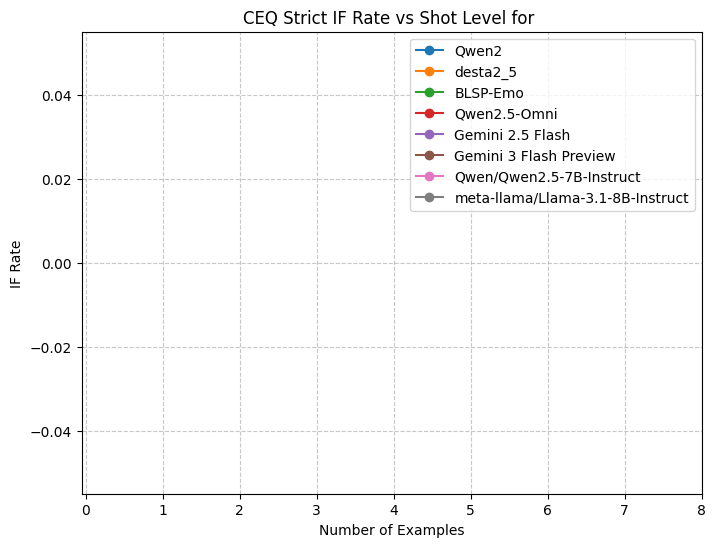

In [ ]:
for group in ["CoT"]:
    plt.figure(figsize=(8, 6))
    for model in MODEL_ORDER:
        sub_tmp = DF_ceq[(DF_ceq["IF_task_group"] == group) & (DF_ceq["model"] == model)]
        plt.plot(
            sub_tmp["shot_level"],
            sub_tmp["if_rate_strict"],
            marker='o',
            label=MAP_MODEL_NAME[model]
        )
    plt.title(f"CEQ Strict IF Rate vs Shot Level for {group}")
    plt.xlabel("Number of Examples")
    plt.ylabel("IF Rate")
    plt.xticks(range(9))
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.savefig(f"figures/plots_ceq_if_rate_{group}.png", dpi=300)

In [26]:
avg, std = {}, {}
for k in outs.keys():
    tables = [table for table in outs[k]]
    out = pd.concat(tables, axis=0, keys=list(range(len(tables))), names=["Shot Level"])
    out = out.reorder_levels(["model", "Shot Level"]).sort_index()
    avg[k] = out.mean(axis=1)
    std[k] = out.std(axis=1)

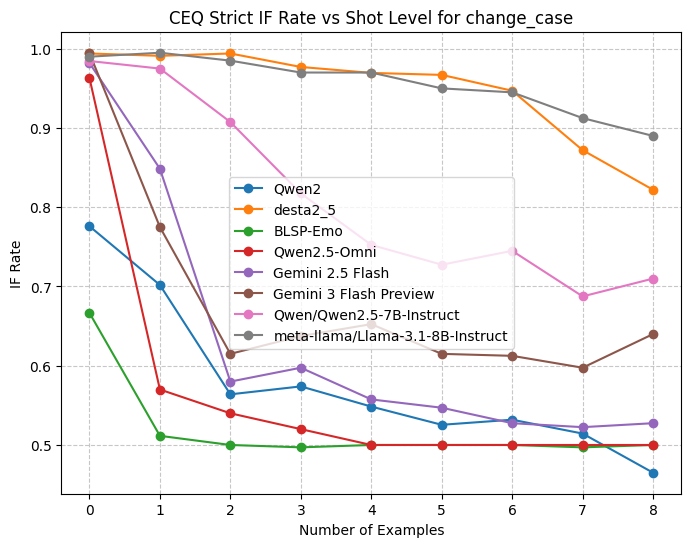

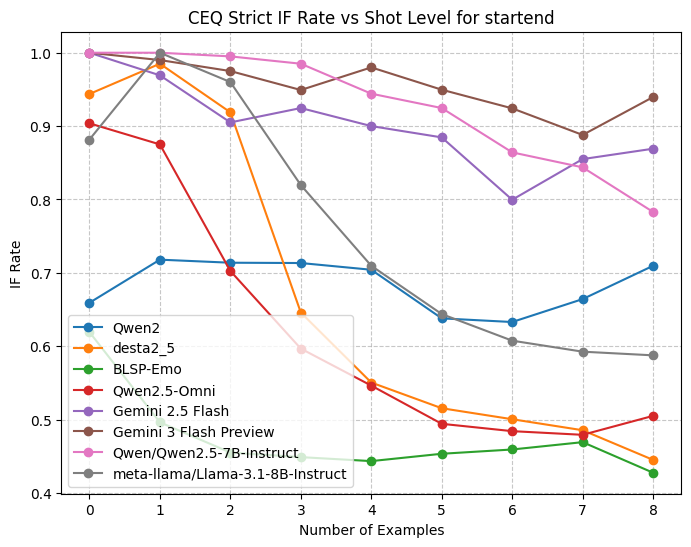

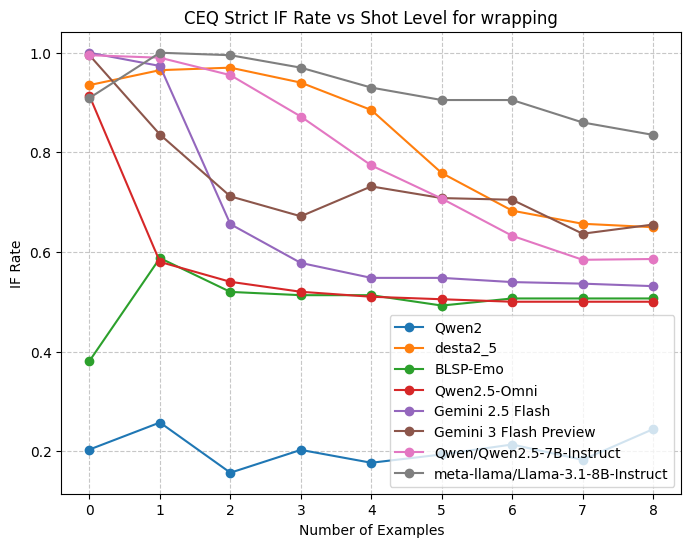

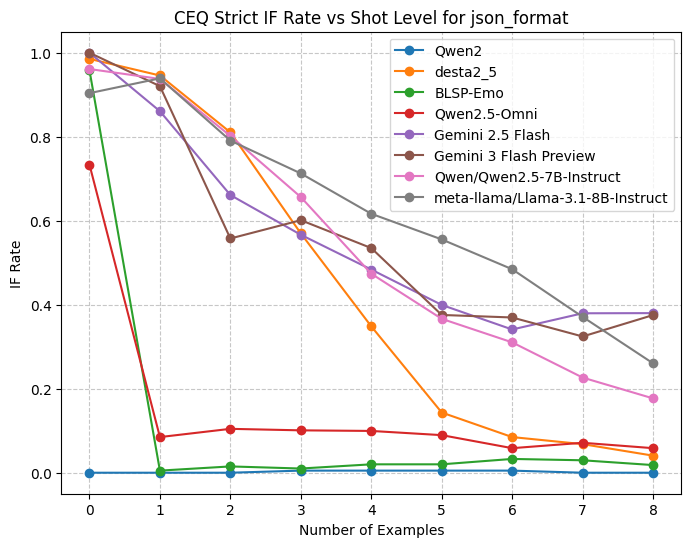

In [27]:
for group in GROUP_ORDER_CEQ:
    plt.figure(figsize=(8, 6))
    for model in MODEL_ORDER:
        sub_tmp = DF_ceq[(DF_ceq["IF_task_group"] == group) & (DF_ceq["model"] == model)]
        plt.plot(
            sub_tmp["shot_level"],
            sub_tmp["if_rate_strict"],
            marker='o',
            label=MAP_MODEL_NAME[model]
        )
    plt.title(f"CEQ Strict IF Rate vs Shot Level for {group}")
    plt.xlabel("Number of Examples")
    plt.ylabel("IF Rate")
    plt.xticks(range(9))
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.savefig(f"figures/plots_ceq_if_rate_{group}.png", dpi=300)

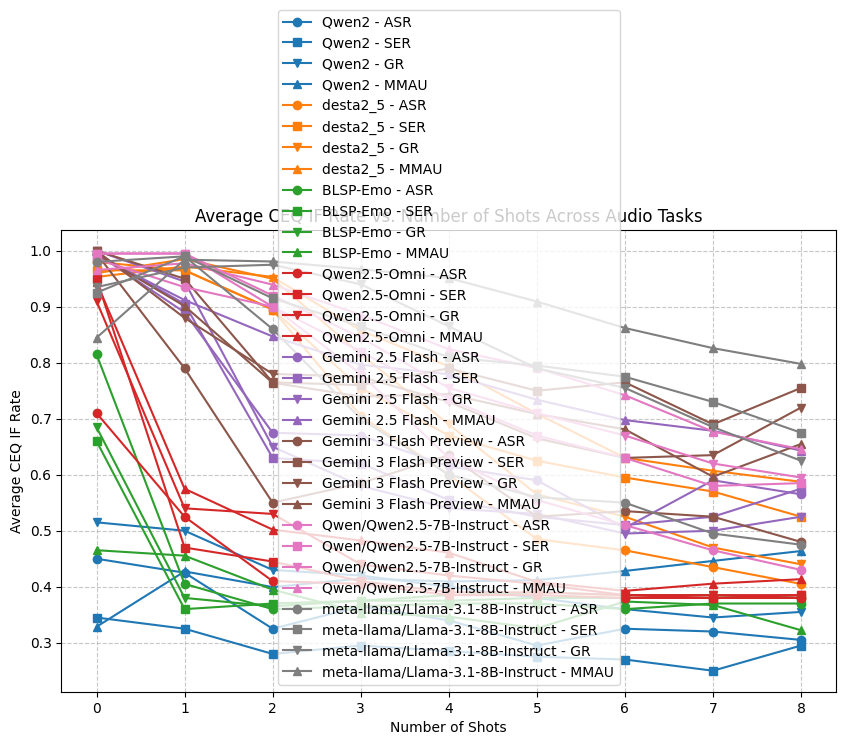

In [132]:
tmp = pd.DataFrame(avg)  # columns: ASR/SER/GR ; index: models ; each cell is a list over shots
# x-axis (0..N-1) based on the length of the first series
shot_levels = list(range(9))
# one color per model (use matplotlib default cycle)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
model_color = {m: colors[i % len(colors)] for i, m in enumerate(MODEL_ORDER)}
# different markers per task
marker_map = {"ASR": "o", "SER": "s", "GR": "v", "MMAU": "^"}  # adjust if your column names differ
plt.figure(figsize=(10, 6))
for model in MODEL_ORDER:
    for audio_task in tmp.columns:
        y = tmp.loc[model, audio_task]
        plt.plot(
            shot_levels, y,
            color=model_color[model],
            marker=marker_map[audio_task],
            label=f"{MAP_MODEL_NAME[model]} - {audio_task}",
        )

plt.legend()
plt.grid(linestyle="--", alpha=0.7)
plt.xlabel("Number of Shots")
plt.ylabel("Average CEQ IF Rate")
plt.title("Average CEQ IF Rate vs. Number of Shots Across Audio Tasks")
plt.show()


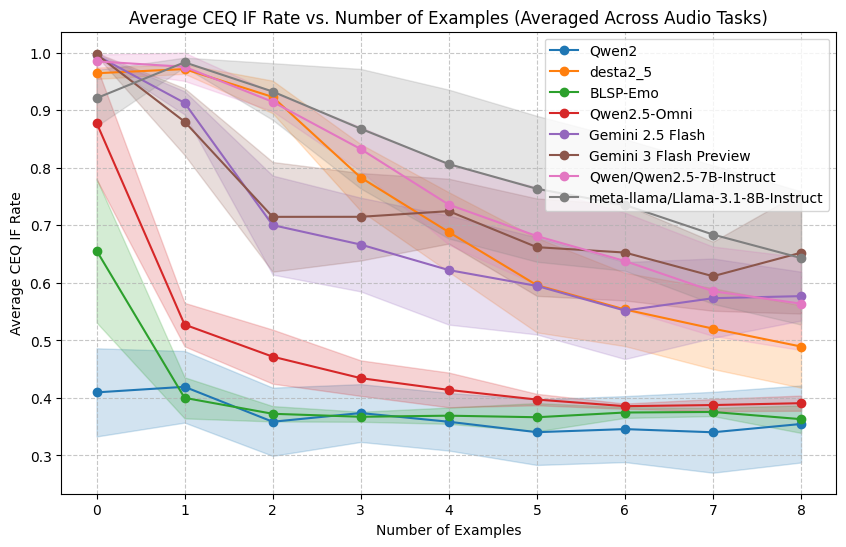

In [134]:
tmp = pd.DataFrame(avg)
avg["avg"] = tmp.mean(axis=1)
std["avg"] = tmp.std(axis=1)
plt.figure(figsize=(10, 6))
for model in MODEL_ORDER:
    y = avg["avg"][model]
    plt.plot(
        shot_levels, y,
        color=model_color[model],
        marker="o",
        label=f"{MAP_MODEL_NAME[model]}",
    )
    plt.fill_between(
        shot_levels,
        y - std["avg"][model],
        y + std["avg"][model],
        alpha=0.2,
        color=model_color[model],
    )
plt.legend()
plt.grid(linestyle="--", alpha=0.7)
plt.xlabel("Number of Examples")
plt.ylabel("Average CEQ IF Rate")
plt.title("Average CEQ IF Rate vs. Number of Examples (Averaged Across Audio Tasks)")
plt.savefig(f"figures/plots_ceq_if_rate_avg.png", dpi=300)
plt.show()

In [ ]:
tmp = pd.DataFrame(avg)
avg["avg"] = tmp.mean(axis=1)
std["avg"] = tmp.std(axis=1)
plt.figure(figsize=(10, 6))
for model in MODEL_ORDER:
    y = avg["avg"][model]
    plt.plot(
        shot_levels, y,
        color=model_color[model],
        marker="o",
        label=f"{MAP_MODEL_NAME[model]}",
    )
plt.legend()
plt.grid(linestyle="--", alpha=0.7)
plt.xlabel("Number of Shots")
plt.ylabel("Average CEQ IF Rate")
plt.title("Average CEQ IF Rate vs. Number of Shots (Averaged Across Audio Tasks)")
plt.show()

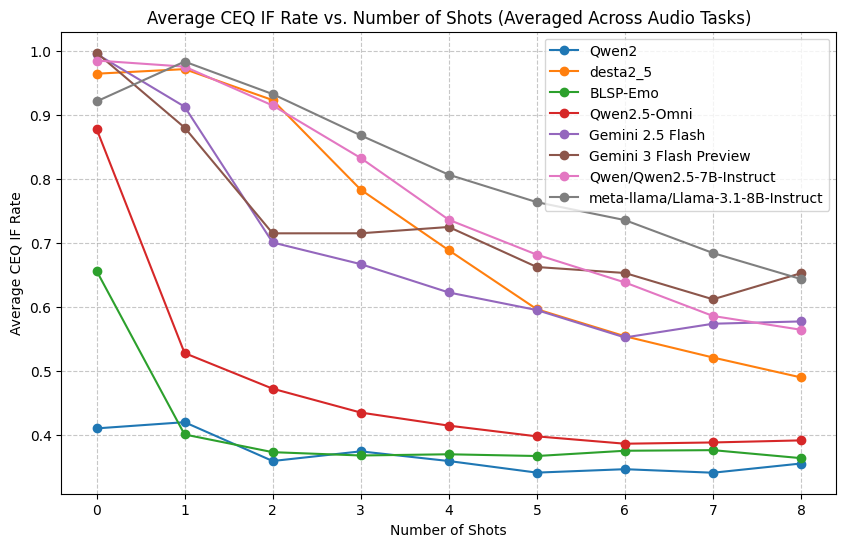

In [136]:
tmp = pd.DataFrame(avg)
avg["avg"] = tmp.mean(axis=1)
std["avg"] = tmp.std(axis=1)
plt.figure(figsize=(10, 6))
for model in MODEL_ORDER:
    y = avg["avg"][model]
    plt.plot(
        shot_levels, y,
        color=model_color[model],
        marker="o",
        label=f"{MAP_MODEL_NAME[model]}",
    )
plt.legend()
plt.grid(linestyle="--", alpha=0.7)
plt.xlabel("Number of Shots")
plt.ylabel("Average CEQ IF Rate")
plt.title("Average CEQ IF Rate vs. Number of Shots (Averaged Across Audio Tasks)")
plt.show()

In [137]:
outs_ = {}
for k, v in df_audio_task_ceq.items():
    outs_[k] = []
    for shot_level in v["shot_level"].unique():
        tmp = v.loc[v["shot_level"].eq(shot_level)].copy()
        tmp["model"] = pd.Categorical(tmp["model"], categories=MODEL_ORDER, ordered=True)
        tmp["IF_task_group"] = pd.Categorical(tmp["IF_task_group"], categories=GROUP_ORDER_CEQ, ordered=True)

        out = tmp.pivot_table(
            index="model",
            columns="IF_task_group",
            values="if_rate_strict",
            aggfunc="mean",
            observed=False,
            sort=False,
        )
        outs_[k].append(out)

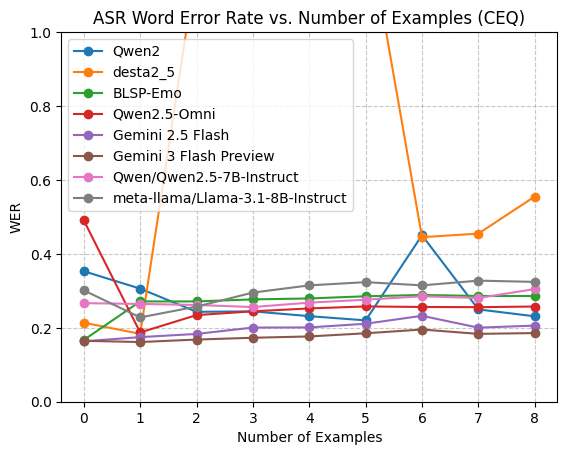

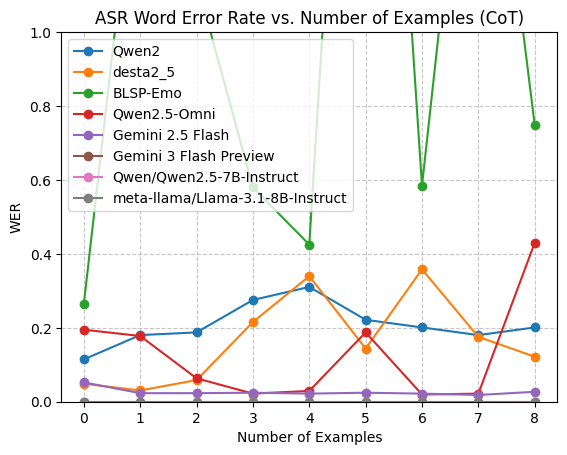

In [43]:
for resp in ["CEQ", "CoT"]:
    for model in MODEL_ORDER:
        y = pt_audio_tasks["mean_performance"]["ASR"][resp][model]
        plt.plot(y, label=MAP_MODEL_NAME[model], marker="o")
    plt.legend(fontsize=10)
    plt.grid(linestyle="--", alpha=0.7)
    plt.ylim(0, 1)
    plt.xlabel("Number of Examples")
    plt.ylabel("WER")
    plt.title(f"ASR Word Error Rate vs. Number of Examples ({resp})")
    plt.savefig(f"figures/plots_asr_wer_{resp}.png", dpi=300)
    plt.show()

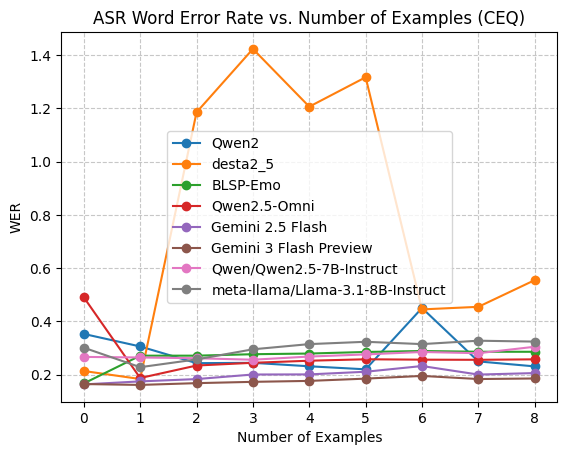

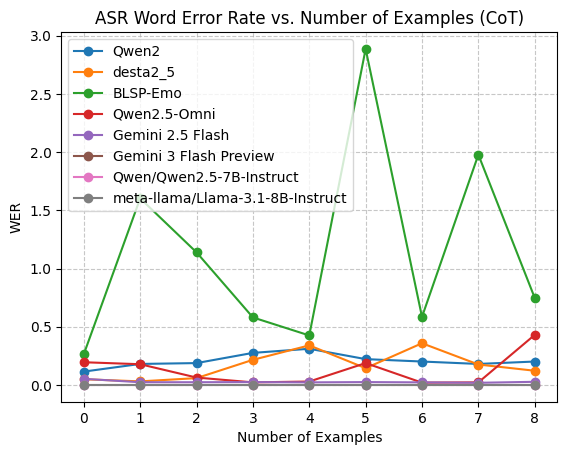

In [40]:
for resp in ["CEQ", "CoT"]:
    for model in MODEL_ORDER:
        y = pt_audio_tasks["mean_performance"]["ASR"][resp][model]
        plt.plot(y, label=MAP_MODEL_NAME[model], marker="o")
    plt.legend(fontsize=10)
    plt.grid(linestyle="--", alpha=0.7)
    plt.xlabel("Number of Examples")
    plt.ylabel("WER")
    plt.title(f"ASR Word Error Rate vs. Number of Examples ({resp})")
    plt.savefig(f"figures/plots_asr_wer_{resp}.png", dpi=300)
    plt.show()

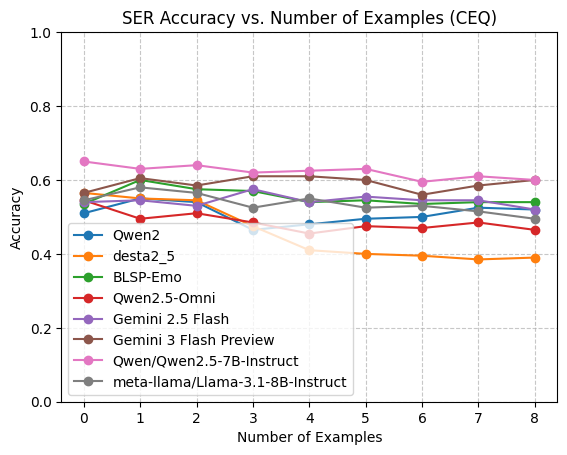

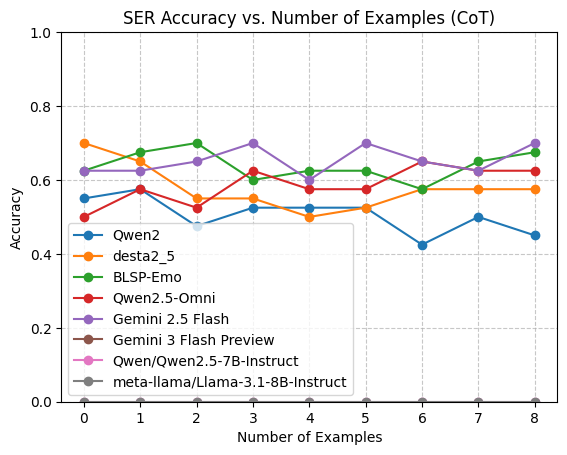

In [41]:
for resp in ["CEQ", "CoT"]:
    for model in MODEL_ORDER:
        y = pt_audio_tasks["mean_performance"]["SER"][resp][model]
        plt.plot(y, label=MAP_MODEL_NAME[model], marker="o")
    plt.legend(fontsize=10)
    plt.grid(linestyle="--", alpha=0.7)
    plt.xlabel("Number of Examples")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.title(f"SER Accuracy vs. Number of Examples ({resp})")
    plt.savefig(f"figures/plots_ser_acc_{resp}.png", dpi=300)
    plt.show()


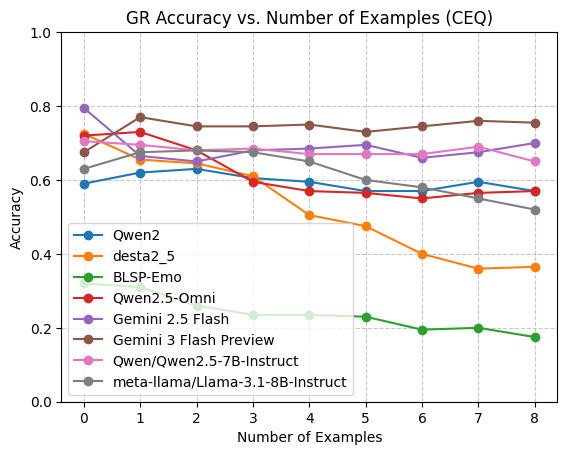

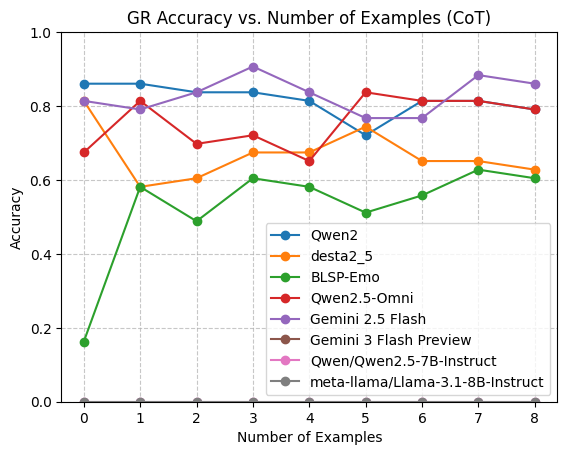

In [42]:
for resp in ["CEQ", "CoT"]:
    for model in MODEL_ORDER:
        y = pt_audio_tasks["mean_performance"]["GR"][resp][model]
        plt.plot(y, label=MAP_MODEL_NAME[model], marker="o")
    plt.legend(fontsize=10)
    plt.grid(linestyle="--", alpha=0.7)
    plt.xlabel("Number of Examples")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.title(f"GR Accuracy vs. Number of Examples ({resp})")
    plt.savefig(f"figures/plots_gr_acc_{resp}.png", dpi=300)
    plt.show()